In [5]:
%load_ext autoreload
%autoreload 2

from setup_func import *

import importlib
import decision_models.a2_wsls
import decision_models.c_nobias_asymmetric_rw
import decision_models.d_lrbias_rw
import decision_models.e_betabias_rw
import decision_models.n_momentum_rw
import decision_models.o_add_rewbias_rw
from decision_models.utils import store_modout, model_comparison, model_comparison_for_paper

from pyEM.fitting import EMfit
# from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms
from pyEM import plotting

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
path_to_summary = f'{data_dir}/clean_all_group_df_summary.csv'
path_to_longform = f'{data_dir}/clean_all_group_longform.csv'

summary_df = pd.read_csv(path_to_summary, index_col=0)
longform = pd.read_csv(path_to_longform, index_col=0)

alcohol_longform = longform[longform['Group'] == 'alcohol']
cannabis_longform = longform[longform['Group'] == 'cannabis']

In [7]:
batches = {
    'alcohol': None,
    'cannabis': None,
}

## EMFit for all alcohol data

In [8]:
modout = {}

save_fit_path=f'{results_dir}/decision/'
if not os.path.exists(save_fit_path):
    os.makedirs(save_fit_path)
if os.path.exists(f'{save_fit_path}/alcohol_decision_models.pkl'):
    print('Loading existing decision models')
    with open(f'{save_fit_path}/alcohol_decision_models.pkl', 'rb') as f:
        modout = pickle.load(f)


Loading existing decision models


In [9]:
## Loop over blocks

for block in ['money', 'other']:
    # create a dict of lists with choices and rewards for each subject
    subj_dict = {
        'choices': [],
        'rewards': [],
        'craving_ratings': []
    }

    # Loop through each subject and add their choices and rewards and craving ratings to the dict
    for pid in alcohol_longform.PID.unique():
        subj_dict['choices'] += [np.array([alcohol_longform[
            (alcohol_longform.PID == pid)
            & (alcohol_longform.Type == block)
        ]['Action'].values])]
        subj_dict['rewards'] += [np.array([alcohol_longform[
            (alcohol_longform.PID == pid)
            & (alcohol_longform.Type == block)
        ]['Reward'].values])]
        subj_dict['craving_ratings'] += [np.array([alcohol_longform[
            (alcohol_longform.PID == pid)
            & (alcohol_longform.Type == block)
        ]['Craving Rating'].values])]

    # Create the all_data list of lists required for pyEM
    all_data = []
    for idx, (choices, rewards, craving_ratings) in enumerate(zip(subj_dict['choices'], subj_dict['rewards'], subj_dict['craving_ratings'])):
        all_data += [[choices, rewards, craving_ratings]]

    # Loop through each model and fit it to the data
    for model_name, param_names, fit_func in [
        (f'a2_wsls_{block}', ['eps'], decision_models.a2_wsls.fit),
        (f'c_nobias_asymmetric_rw_{block}', ['beta', 'lr_pos', 'lr_neg'], decision_models.c_nobias_asymmetric_rw.fit),
        (f'd_lrbias_rw_{block}', ['beta', 'lr', 'mod'], decision_models.d_lrbias_rw.fit),
        (f'e_betabias_rw_{block}', ['beta', 'lr', 'mod'], decision_models.e_betabias_rw.fit),
        (f'n_momentum_rw_{block}', ['beta', 'lr', 'mod', 'mom_lr'], decision_models.n_momentum_rw.fit),
        (f'o_add_rewbias_rw_{block}', ['beta', 'lr', 'mod'], decision_models.o_add_rewbias_rw.fit),
    ]:
        if model_name in modout:
            print(f'{model_name} already fit')
            continue

        print(f'Fitting {model_name} - {block.capitalize()} block')
        m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(all_data, fit_func, param_names)
        modout = store_modout(
            modout, model_name, param_names, subj_dict, fit_func, 
            m, inv_h, posterior, NPL, NLPrior, NLL
        )


Fitting a2_wsls_money - Money block
2192.925 (000), 2047.190 (001), 2038.749 (002), 2036.211 (003), 2035.172 (004), 2034.683 (005), 2034.437 (006), 2034.307 (007), 2034.238 (008), 2034.201 (009), 2034.181 (010), 2034.170 (011), 2034.164 (012), 2034.161 (013), 2034.159 (014), 2034.158 (015),  -- CONVERGED!!!!!
c_nobias_asymmetric_rw_money already fit
d_lrbias_rw_money already fit
e_betabias_rw_money already fit
n_momentum_rw_money already fit
o_add_rewbias_rw_money already fit
Fitting a2_wsls_other - Other block
2270.360 (000), 2105.716 (001), 2098.690 (002), 2096.312 (003), 2095.240 (004), 2094.695 (005), 2094.403 (006), 2094.243 (007), 2094.152 (008), 2094.102 (009), 2094.072 (010), 2094.055 (011), 2094.045 (012), 2094.040 (013), 2094.037 (014), 2094.035 (015), 2094.034 (016), 2094.034 (017),  -- CONVERGED!!!!!
c_nobias_asymmetric_rw_other already fit
d_lrbias_rw_other already fit
e_betabias_rw_other already fit
n_momentum_rw_other already fit
o_add_rewbias_rw_other already fit


In [12]:
skipped_models = list(set([elem[:-6] for elem in modout.keys() if 'b_nobias' in elem or 'heuristic' in elem or 'decay' in elem or 'fictive' in elem or 'p_asymmetric' in elem or 'mult' in elem or 'm_rew' in elem]))
fig_money, fig_other, df_money, df_other = model_comparison_for_paper(modout, 'cannabis', ic_type='bic', skip_models=skipped_models, figsize=(35*mm, 21*mm))
display(df_money)
display(df_other)

,Model,Type,IC,Delta-IC
0,c_nobias_asymmetric_rw,Money,3424.300958,11.453208
1,d_lrbias_rw,Money,3437.579083,24.731333
2,e_betabias_rw,Money,3484.175219,71.327469
3,n_momentum_rw,Money,3611.560244,198.712494
4,o_add_rewbias_rw,Money,3412.847750,0.000000
5,a2_wsls,Money,4223.986066,811.138316


,Model,Type,IC,Delta-IC
0,c_nobias_asymmetric_rw,Other,3824.782579,35.328866
1,d_lrbias_rw,Other,3789.453713,0.000000
2,e_betabias_rw,Other,3839.745266,50.291553
3,n_momentum_rw,Other,3999.895433,210.441720
4,o_add_rewbias_rw,Other,3799.277296,9.823582
5,a2_wsls,Other,4379.410120,589.956407


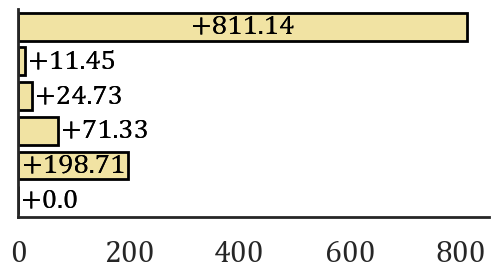

In [13]:
fig_money

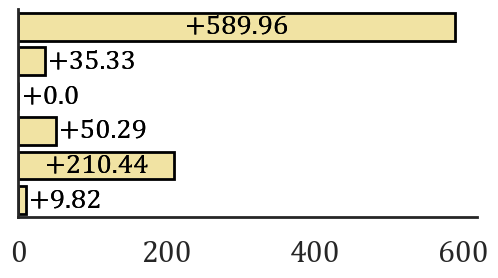

In [14]:
fig_other

## EMFit for all cannabis data

In [15]:
modout = {}

save_fit_path=f'{results_dir}/decision/'
if not os.path.exists(save_fit_path):
    os.makedirs(save_fit_path)
if os.path.exists(f'{save_fit_path}/cannabis_decision_models.pkl'):
    print('Loading existing decision models')
    with open(f'{save_fit_path}/cannabis_decision_models.pkl', 'rb') as f:
        modout = pickle.load(f)


Loading existing decision models


In [16]:
## Loop over blocks

for block in ['money', 'other']:
    # create a dict of lists with choices and rewards for each subject
    subj_dict = {
        'choices': [],
        'rewards': [],
        'craving_ratings': []
    }

    # Loop through each subject and add their choices and rewards and craving ratings to the dict
    for pid in cannabis_longform.PID.unique():
        subj_dict['choices'] += [np.array([cannabis_longform[
            (cannabis_longform.PID == pid)
            & (cannabis_longform.Type == block)
        ]['Action'].values])]
        subj_dict['rewards'] += [np.array([cannabis_longform[
            (cannabis_longform.PID == pid)
            & (cannabis_longform.Type == block)
        ]['Reward'].values])]
        subj_dict['craving_ratings'] += [np.array([cannabis_longform[
            (cannabis_longform.PID == pid)
            & (cannabis_longform.Type == block)
        ]['Craving Rating'].values])]

    # Create the all_data list of lists required for pyEM
    all_data = []
    for idx, (choices, rewards, craving_ratings) in enumerate(zip(subj_dict['choices'], subj_dict['rewards'], subj_dict['craving_ratings'])):
        all_data += [[choices, rewards, craving_ratings]]

    # Loop through each model and fit it to the data
    for model_name, param_names, fit_func in [
        (f'a2_wsls_{block}', ['eps'], decision_models.a2_wsls.fit),
        (f'c_nobias_asymmetric_rw_{block}', ['beta', 'lr_pos', 'lr_neg'], decision_models.c_nobias_asymmetric_rw.fit),
        (f'd_lrbias_rw_{block}', ['beta', 'lr', 'mod'], decision_models.d_lrbias_rw.fit),
        (f'e_betabias_rw_{block}', ['beta', 'lr', 'mod'], decision_models.e_betabias_rw.fit),
        (f'n_momentum_rw_{block}', ['beta', 'lr', 'mod', 'mom_lr'], decision_models.n_momentum_rw.fit),
        (f'o_add_rewbias_rw_{block}', ['beta', 'lr', 'mod'], decision_models.o_add_rewbias_rw.fit),
    ]:
        if model_name in modout:
            print(f'{model_name} already fit')
            continue

        print(f'Fitting {model_name} - {block.capitalize()} block')
        m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(all_data, fit_func, param_names)
        modout = store_modout(
            modout, model_name, param_names, subj_dict, fit_func, 
            m, inv_h, posterior, NPL, NLPrior, NLL
        )


Fitting a2_wsls_money - Money block
2173.521 (000), 2014.705 (001), 2007.087 (002), 2004.325 (003), 2002.998 (004), 2002.282 (005), 2001.871 (006), 2001.627 (007), 2001.481 (008), 2001.390 (009), 2001.335 (010), 2001.300 (011), 2001.280 (012), 2001.267 (013), 2001.259 (014), 2001.253 (015), 2001.252 (020), 2001.249 (021), 2001.245 (022),  -- CONVERGED!!!!!
c_nobias_asymmetric_rw_money already fit
d_lrbias_rw_money already fit
e_betabias_rw_money already fit
n_momentum_rw_money already fit
o_add_rewbias_rw_money already fit
Fitting a2_wsls_other - Other block
2131.255 (000), 1986.666 (001), 1979.515 (002), 1977.458 (003), 1976.642 (004), 1976.276 (005), 1976.097 (006), 1976.008 (007), 1975.962 (008), 1975.940 (009), 1975.928 (010), 1975.923 (011), 1975.919 (012), 1975.917 (013), 1975.917 (014),  -- CONVERGED!!!!!
c_nobias_asymmetric_rw_other already fit
d_lrbias_rw_other already fit
e_betabias_rw_other already fit
n_momentum_rw_other already fit
o_add_rewbias_rw_other already fit


In [17]:
skipped_models = list(set([elem[:-6] for elem in modout.keys() if 'b_nobias' in elem or 'heuristic' in elem or 'decay' in elem or 'fictive' in elem or 'p_asymmetric' in elem or 'mult' in elem or 'm_rew' in elem]))
fig_money, fig_other, df_money, df_other = model_comparison_for_paper(modout, 'cannabis', ic_type='bic', skip_models=skipped_models, figsize=(35*mm, 21*mm))
display(df_money)
display(df_other)

,Model,Type,IC,Delta-IC
0,c_nobias_asymmetric_rw,Money,3810.607860,10.966603
1,d_lrbias_rw,Money,3823.757101,24.115843
2,e_betabias_rw,Money,3831.984607,32.343349
3,n_momentum_rw,Money,4020.507369,220.866111
4,o_add_rewbias_rw,Money,3799.641258,0.000000
5,a2_wsls,Money,4192.902837,393.261579


,Model,Type,IC,Delta-IC
0,c_nobias_asymmetric_rw,Other,3814.185016,91.044146
1,d_lrbias_rw,Other,3723.140870,0.000000
2,e_betabias_rw,Other,3761.902568,38.761698
3,n_momentum_rw,Other,3965.757049,242.616179
4,o_add_rewbias_rw,Other,3761.304769,38.163899
5,a2_wsls,Other,4108.185821,385.044951


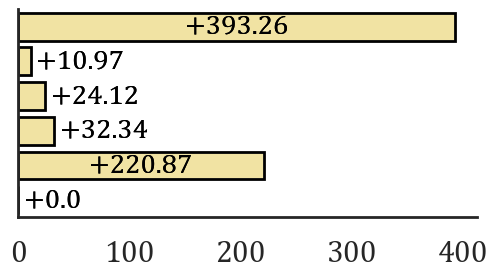

In [18]:
fig_money

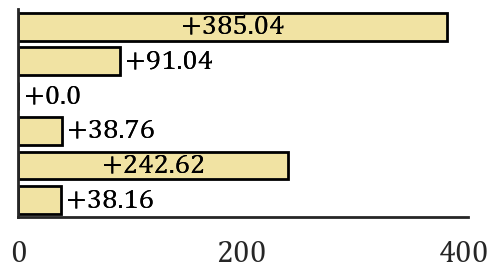

In [19]:
fig_other